In [1]:
import numpy as np
import scipy
import theano
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
sns.set_style('white')
%matplotlib inline

# Probability Primer

## Distributions

### Beta distribution

In [2]:
from scipy.stats import beta

/Users/murat/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


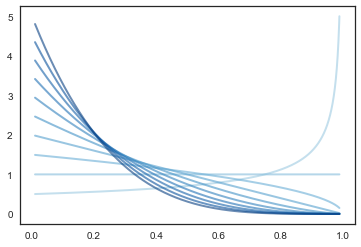

In [3]:
α = 1
colors = sns.palettes.color_palette("Blues",15)[5:]
for i in range(10):
    β = 0.5*(i+1)
    x = np.linspace(1e-2, 1-1e-2, 1e4)
    _ = sns.plt.plot(x, beta.pdf(x, α, β), color=colors[i],
                     lw=2, alpha=0.6, label='')

# Probabilistic Graphical Model Inference Example

## Cheater - Coin Model

### Data Generation

We assume that there is a cheater who alternates between a fair and cheating coin. Everyday, the cheater picks the coin to use that day and subsequently makes 100 tests with that coin, betting on heads. We only see the total number of success on that day, and want to infer (a) the probability with which he selects the cheating coin, (b) the altered probability of heads with the loaded coin (i.e. exactly how much he is cheating). We create the data with success probability 0.5 and 0.7 for the fair and loaded coin, respectively. We assume exactly the loaded coin is chosen in exactly half of the days, but the order is random. 

In [4]:
θ_real = 0.3; N = 100; p_real = [0.5,0.7]; D = 1500
cheat_days = np.random.binomial(1, θ_real, D)
data = np.random.binomial(N, [p_real[cheat_days[i]] for i in range(D)], D)

### Inference

We have a 'decision' variable that holds whether the loaded or fair coin is being used that day, with the probability of this switch being a Beta distributed random variable. We have as many decision variables as the number of days -- one decision per day, thus one decision r.v. per day. We have two probability values, both Beta distributed. 

In [5]:
model = pm.Model()
with model:
    θ = pm.Beta('theta',alpha=3, beta=3, testval=0.5)
    d = pm.Bernoulli('decision', p=θ, shape=(D))
    p = pm.Beta('dice_loading',alpha=3, beta=3, shape=(2), testval=[0.1,0.9])
    p_chosen = pm.math.switch(d, p[1], p[0])
    n = pm.Binomial('success',n=N, p=p_chosen, observed=data)
    trace = pm.sample(1000, tune=500, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [dice_loading_logodds__, theta_logodds__]
>BinaryGibbsMetropolis: [decision]
100%|██████████| 1500/1500 [04:12<00:00,  5.94it/s]/Users/murat/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

Tuning was enabled throughout the whole trace.
Only one chain was sampled, this makes it impossible to run some convergence checks


Now let's overlay the real values (which we know because this is a simulated dataset) and the values from our sampling based learning procedure:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e379be0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e3aaf60>]], dtype=object)

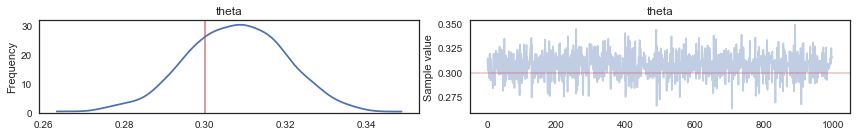

In [6]:
pm.traceplot(trace, varnames=['theta'], lines={'theta':θ_real})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e5d7ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11e672b00>]], dtype=object)

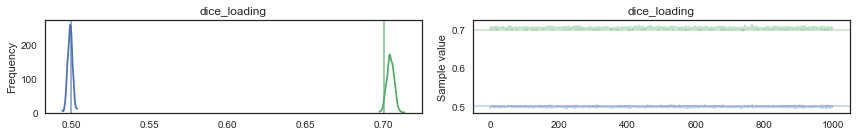

In [7]:
pm.traceplot(trace, varnames=['dice_loading'], lines={'dice_loading':p_real})

Instead of point estimates, we might be interested in the 95% confidence interval for each of these parameters. We can find that easily as follows:

In [14]:
print(pm.df_summary(trace,varnames=['theta','dice_loading'],alpha=0.05))

                     mean        sd  mc_error   hpd_2.5  hpd_97.5
theta            0.307456  0.012540  0.000333  0.280050  0.329657
dice_loading__0  0.499392  0.001543  0.000043  0.496487  0.502389
dice_loading__1  0.704294  0.002314  0.000080  0.699844  0.708527


/Users/murat/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: df_summary has been deprecated. In future, use summary instead.
  """Entry point for launching an IPython kernel.


Let's find a day that is hard to distinguish, with a roll count of around 60. This could be a cheating day, or a really luck day with the fair coin.

In [9]:
find_nearest = lambda array, value: (np.abs(array-value)).argmin()

In [10]:
idx = find_nearest(data,60)

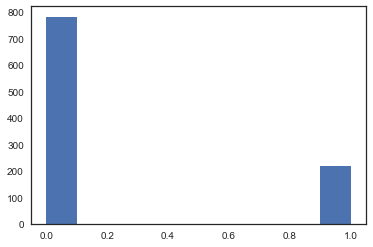

In [11]:
_ = sns.plt.hist(trace.get_values('decision')[:,idx])

Based on the above plot, the MCMC inference procedure suggests this is a fair coin day. Let's see what the reality was:

In [12]:
cheat_days[idx]

0

It turns out that it was indeed a really lucky day with the fair coin.

Now let's analyze all the days to see whether if they were inferred by the PGM to be a "cheat day" or a "fair coin day". We define the days where the decision to cheat is inferred to have a higher probability as cheat days, and vice versa. We also define a baseline by identifying any days where the gambler won more than he lost as "cheat days".

In [13]:
pred_cheat_days = trace.get_values('decision').mean(0)>=0.5
baseline = data>=0.5*N
print("Cheat day prediction accuracy")
print("PGM: {0:.2f}%".format((cheat_days==pred_cheat_days).sum()/D*100))
print("Baseline: {0:.2f}%".format((cheat_days==baseline).sum()/D*100))

Cheat day prediction accuracy
PGM: 98.87%
Baseline: 62.40%
